# Counterfactuals benchmark

## Data and model

This counterfactual benchmark will use a model for a loan approval generated in the [benchmark models repository](https://github.com/ruivieira/benchmark-models/tree/main/minimal-numerical).

The model is a minimal classification model with numerical-only input features.

The input features are:

- Age
- Debt
- Years employed
- Income

The classification label is a binary `0,1` corresponding to not approved and approved.

In [69]:
from joblib import load
from alibi.explainers import CounterFactual
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs

In [70]:
clf = load("models/model.joblib")

In [71]:
predict_fn = lambda x: clf.predict_proba(x)

In [72]:
shape = (1,4)
print(shape)

(1, 4)


## Search with defaults

We will use the following values:

- `feature_range`, the feature ranges can be extracted from the training data[^1]

[^1]: https://github.com/ruivieira/benchmark-models/blob/main/minimal-numerical/notebooks/01-data-exploration.ipynb

In [73]:
explainer = CounterFactual(predict_fn, 
                           feature_range=([18.0,1.0,0.0,0.0], [80.0, 7.0, 30.0, 300.0]),
                           shape=shape, 
                           target_class=[1], 
                           target_proba=0.6,
                           learning_rate_init=1.0, # default 0.1,
                           eps=1.0,
                           early_stop=200,
                           tol=0.09)

In [74]:
df = np.array([21.0, 3.5, 5.0, 100]).reshape(1, -1)
df

array([[ 21. ,   3.5,   5. , 100. ]])

In [75]:
print(predict_fn(df))
print(clf.predict(df))

[[0.6 0.4]]
[0]


In [76]:
p = [(score, predict_fn(np.array([21.0, score, 5.0, 100]).reshape(1, -1))[0][1]) for score in np.linspace(0.0, 7.0, num=100)]

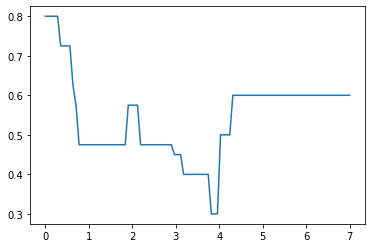

In [77]:
plt.plot([x[0] for x in p], [y[1] for y in p])

In [78]:
cf = explainer.explain(df)

In [84]:
cf['params']

{'shape': (1, 4),
 'distance_fn': 'l1',
 'target_proba': 0.6,
 'target_class': [1],
 'max_iter': 1000,
 'early_stop': 200,
 'lam_init': 0.1,
 'max_lam_steps': 10,
 'tol': 0.09,
 'learning_rate_init': 1.0,
 'eps': 1.0,
 'init': 'identity',
 'decay': True,
 'write_dir': None,
 'debug': False,
 'feature_range': ([18.0, 1.0, 0.0, 0.0], [80.0, 7.0, 30.0, 300.0]),
 'is_model': False,
 'is_keras': False}

In [85]:
print(cf.data['cf']['X'])
print("diff: ", cf.data['cf']['X'] - df)

[[ 21.001236    4.2502303   5.0023284 100.       ]]
diff:  [[0.00123596 0.75023031 0.0023284  0.        ]]


In [88]:
np.linalg.norm(cf.data['cf']['X'] - df)

0.7502349435969725

In [87]:
predict_fn(cf.data['cf']['X'])

array([[0.4, 0.6]])

# DiCE counterfactuals

In [ ]:
import dice_ml
from dice_ml.utils import helpers # helper functions

Although DiCE can use the original training data, to generate counterfactuals we can simply use the dataset's metadata along with the feature domain.
The domains are available in the original model's [documentation](https://github.com/ruivieira/benchmark-models/tree/main/minimal-numerical).

In [ ]:
features = {
    'Age': [13, 81],
    'Debt': [0, 27],
    'YearsEmployed': [0, 20],
    'Income': [0, 10000]}

d = dice_ml.data.Data(features=features, outcome_name='Approved')

In [ ]:
from dice_ml.model_interfaces import klearn_model

m = dice_ml.model.Model(model=clf, backend={"model": "sklearn_model.SklearnModel", "explainer": "dice_sklearn.DiceSklearn"})

In [ ]:
# df = np.array([21.0, 0.1, 0.1, 100]).reshape(1, -1)
query = {'Age': 21, 'Debt': 0.1, 'YearsEmployed': 0.1, 'Income': 100}

In [ ]:
exp = dice_ml.Dice(d, m)

In [ ]:
dice_exp = dice_ml.generate_counterfactuals(query,
                total_CFs=4, desired_class="1",
                proximity_weight=1.5, diversity_weight=1.0)